<a href="https://colab.research.google.com/github/BRIAN12682/Automation-Projects/blob/main/Brain_Tumour_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]
!pip install torch-fidelity
!pip install scipy
!pip install pytorch-fid
!pip install torch-summary
!pip install matplotlib==3.5
!pip install captum==0.5

In [ ]:
import os, sys, itertools, glob, torch, torchvision, random, shutil, uuid, io
import numpy as np
from numpy import asarray
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import ArtistAnimation
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms, models
import torchvision.utils as vutils
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split, ConcatDataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

torch.manual_seed(46)
device = "cuda" if torch.cuda.is_available() else "cpu"

from pytorch_fid.fid_score import calculate_fid_given_paths
from torchmetrics.image.fid import FrechetInceptionDistance
fid_sc = FrechetInceptionDistance(normalize=True).to(device)
from torchmetrics.image.inception import InceptionScore
inception_sc = InceptionScore(normalize=True).to(device)

import PIL.Image
from PIL import ImageFile
import IPython.display
from IPython.display import HTML

from captum.attr import visualization as viz
from captum.attr import GuidedGradCam, NoiseTunnel
from matplotlib import cm

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 206MB/s]
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import zipfile
import os

# Specify the path to the zip file on Google Drive
zip_file_path = '/content/drive/My Drive/archive.zip'


extraction_path = '/content/dataset/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)


In [22]:
print('Classes: ', os.listdir("/content/drive/MyDrive/train"))

Classes:  ['no', 'yes']


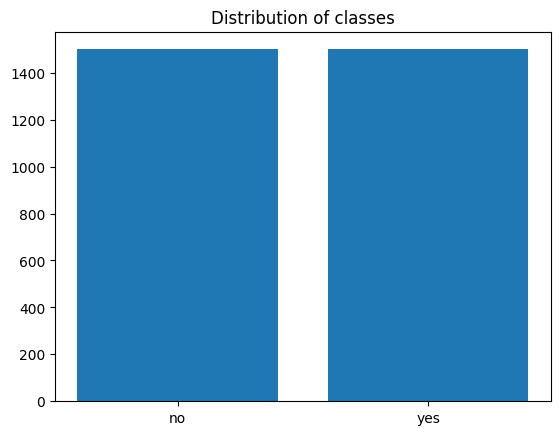

In [24]:
classes = os.listdir("/content/drive/MyDrive/train")
sum_images = []
for i in range(2):
    img_base_path = "/content/drive/MyDrive/train/" + str(classes[i])
    images = os.listdir(img_base_path)
    sum_images.append(len(images))
plt.bar(classes, sum_images)
plt.title('Distribution of classes')
plt.show()

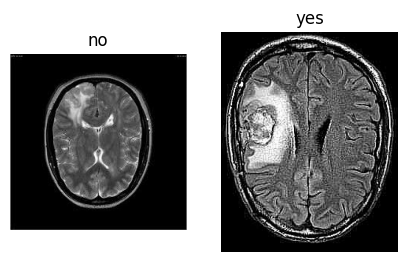

In [26]:
images = []
paths = []

fig,ax = plt.subplots(1,2,figsize = (5,5))
ax = ax.ravel()

for i in range(2):
    img_base_path = "/content/drive/MyDrive/train/" + str(classes[i])
    timages = os.listdir(img_base_path)
    images_path_to_display = os.path.join(img_base_path, str(timages[0]))
    paths.append(images_path_to_display)
    img = Image.open(images_path_to_display)
    images.append(img)
    image = images[i]
    ax[i].imshow(image)
    ax[i].set_title(classes[i])
    ax[i].axis('off')

plt.show()

In [27]:
data = datasets.ImageFolder('/content/drive/MyDrive/train')
generator = torch.Generator().manual_seed(46)
train, validation = random_split(data, [0.8, 0.2], generator = generator)
print(len(train))
print(len(validation))

2400
600


In [28]:
class loadData(Dataset):
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])

        y = self.dataset[index][1]
        return x, y

    def __len__(self):
        return len(self.dataset)

In [29]:
train_transform = transforms.Compose([transforms.Resize((64, 64)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

no_transform = transforms.Compose([transforms.Resize((64, 64)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   transforms.ToPILImage()])